In [7]:
!pip install windrose

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths to your data
gps_file = '/content/drive/MyDrive/Cloud data/Serengeti_HMM.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date1'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date1'].dt.date
gps_data['year'] = gps_data['date1'].dt.year
gps_data['month'] = gps_data['date1'].dt.month
gps_data = gps_data.sort_values(by=['ID','date'])

# Function to calculate heading direction from x, y coordinates
def calculate_heading(x, y):
    heading = np.arctan2(np.diff(y), np.diff(x))
    heading = np.degrees(heading)
    heading = np.where(heading < 0, heading + 360, heading)
    return np.concatenate(([np.nan], heading))

# Convert GPS data to heading direction
gps_data['heading'] = calculate_heading(gps_data['x1_'], gps_data['y1_'])

# Calculate average heading direction per month per year
avg_heading = gps_data.groupby(['ID', 'year', 'month'])['heading'].mean().reset_index()


<ipython-input-3-8214163c3e2d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)


<xarray.Dataset>
Dimensions:      (y: 144, x: 135, time: 106)
Coordinates:
  * y            (y) float64 1.01e+07 1.01e+07 1.009e+07 ... 9.392e+06 9.388e+06
  * x            (x) float64 3.725e+05 3.775e+05 ... 1.038e+06 1.042e+06
  * time         (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2023-10-31
    spatial_ref  int32 21036
Data variables:
    rainfall     (time, y, x) float32 nan nan nan nan ... 43.78 44.2 44.2 47.42
Attributes:
    crs:           epsg:21036
    grid_mapping:  spatial_ref


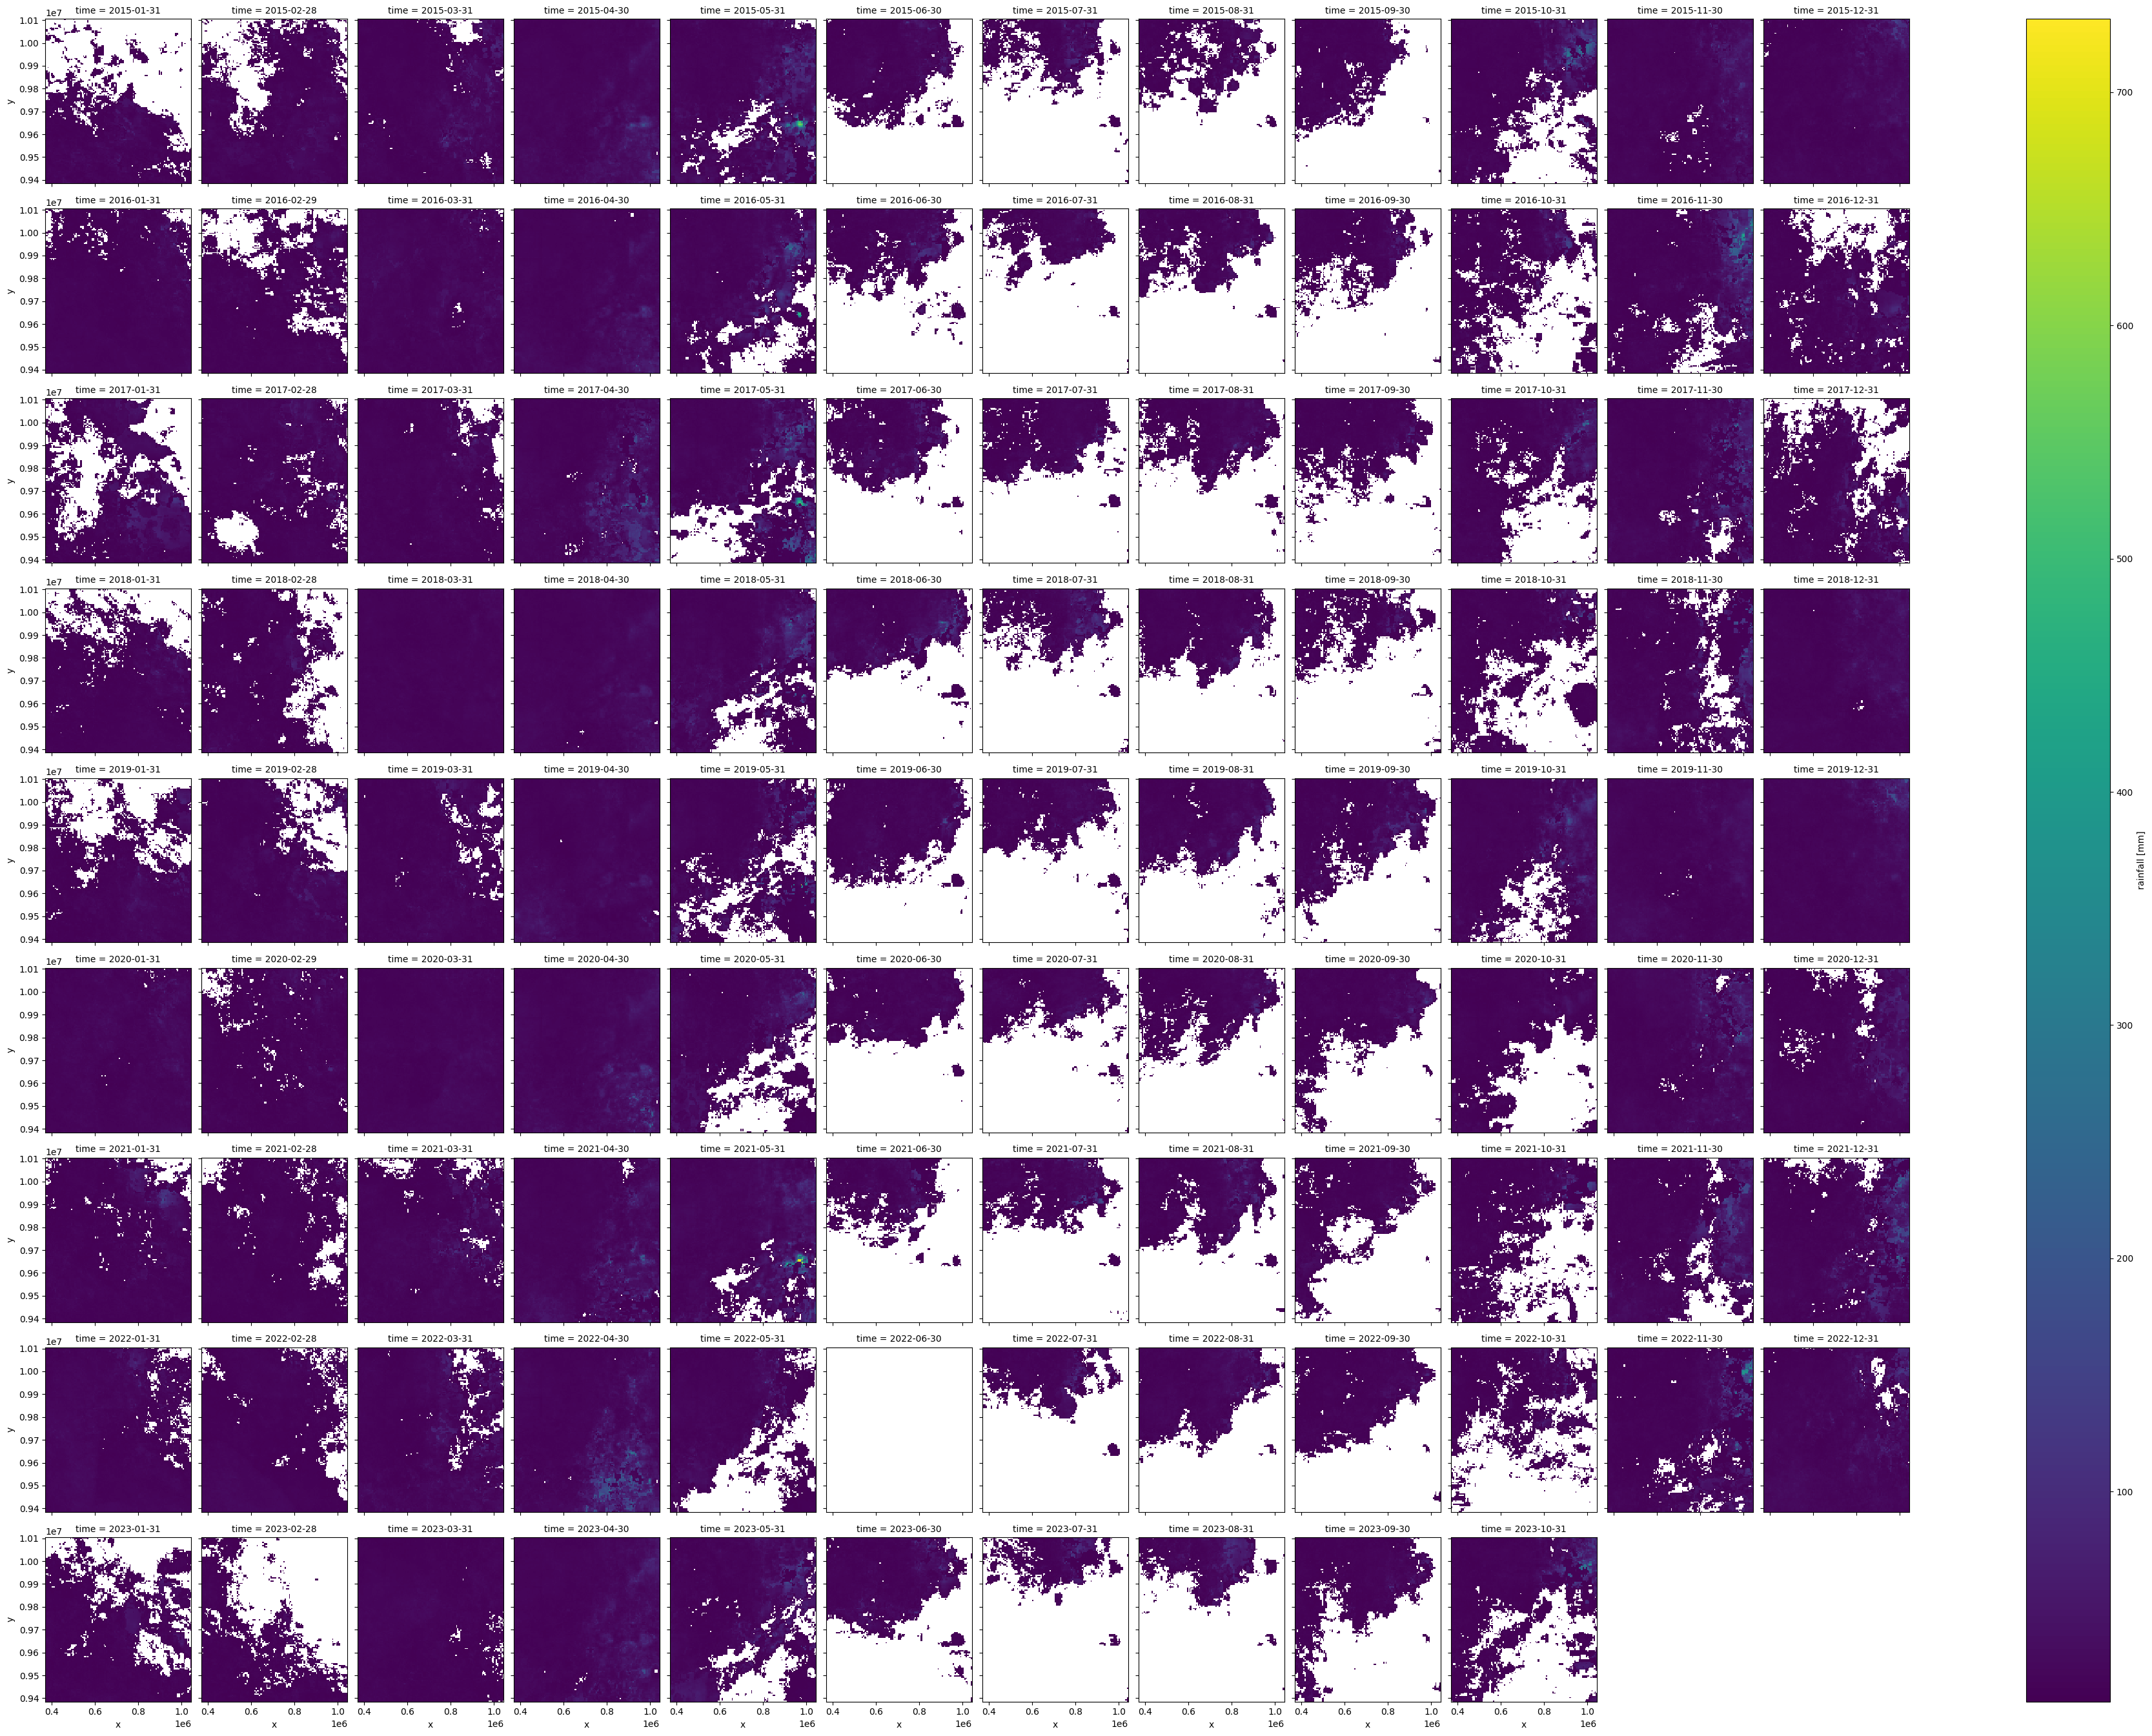

In [21]:
# Load rainfall data
rain = xr.open_dataset('/content/drive/MyDrive/Cloud data/Serengeti_chirps_wide.nc')
threshold = 10
#rain = rain.where(rain['rainfall'] <= threshold, 0)  # Set values below threshold to 0
rain = rain.where(rain >= threshold, other=np.nan)
# Resample to monthly frequency
monthly_ds = rain.resample(time='1M').mean()

# Print the resulting dataset
print(monthly_ds)
monthly_ds.rainfall.plot(col='time', col_wrap=12)

In [23]:
from calendar import month
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
##
image_size = 32
step = 1
lag = 1

# Create an empty array to store image-GPS pairs
xdata = np.zeros((len(gps_data),image_size,image_size,lag))
ydata = np.zeros((len(gps_data),2))
heading = np.zeros(len(gps_data))
years = np.zeros(len(gps_data))
months = np.zeros(len(gps_data))

i=0
for uid in tqdm(gps_data['ID'].unique()):
    current_data = gps_data[gps_data['ID'] == uid]
    # iterate through every other row
    for index, row in current_data.iterrows():

        # if index % step != 0:
        #     continue

        # Extract GPS coordinates and time from the DataFrame
        center_x = row['x1_']
        center_y = row['y1_']
        center_date = row['date1']
        # find the row that is step days later
        next_date = center_date + pd.Timedelta(days=step)
        next_data = current_data[current_data['date1'] == next_date]
        if len(next_data) == 0:
            continue
        next_x = next_data['x1_'].values[0]
        next_y = next_data['y1_'].values[0]

        # Calculate the heading direction from the current location to the next location
        heading[i] = np.arctan2(next_y - center_y, next_x - center_x)
        heading[i] = np.mod(np.degrees(heading[i]), 360)

        ydata[i] = [next_x - center_x, next_y - center_y]

        # Convert latitude and longitude to indices in the xarray dataset
        x_index = np.abs(rain.x - center_x).argmin().values
        y_index = np.abs(rain.y - center_y).argmin().values

        # Find the index corresponding to the center_time in the time dimension
        time_index = np.abs(rain.time - np.datetime64(center_date)).argmin().values
        if time_index - lag < 0:
            continue

        # Extract a subset of the dataset centered around the specified location for 1 week starting at the current time
        subset = rain.isel(x=slice(x_index - image_size//2, x_index + image_size//2),
                            y=slice(y_index - image_size//2, y_index + image_size//2),
                            time=slice(time_index - lag + 1, time_index+1))

        # Extract the 2D array of the variable you want to visualize
        data_array = subset.rainfall.values

        # Check for NaN and infinite values
        #if np.isnan(data_array).any() or np.isinf(data_array).any():
         #   print(f"Warning: NaN or infinite values found in data_array for ID {uid}, index {index}, time_index {time_index}")
          #  print(f"NaN values: {np.sum(np.isnan(data_array))}")
           # print(f"Infinite values: {np.sum(np.isinf(data_array))}")

        # Handle invalid values by replacing NaN and infinite values with 0
        # normalized_data = np.nan_to_num((data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array)))
        data_array = np.nan_to_num(data_array)

        # data_array = np.mean(data_array,axis=0)
        data_array = np.transpose(data_array,[1,2,0])
        xdata[i] = data_array #np.reshape(data_array, (image_size, image_size, 1))
        years[i] = center_date.year
        months[i] = center_date.month
        i += 1


##
print(i)
xdata = xdata[:i]
ydata = ydata[:i]
years = years[:i]
months = months[:i]
heading = heading[:i]

xdata = xdata.astype('float32')
xdata = xdata / np.percentile(xdata,95)
ydata = ydata.astype('float32')
ydata = ydata / np.linalg.norm(ydata,axis=1,keepdims=True)
#heading = np.degrees(heading)
##

100%|██████████| 59/59 [02:08<00:00,  2.17s/it]


31390


In [24]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
from collections import defaultdict
import ipywidgets as widgets

# Step 1: Calculate the average rain per month for each year
average_rain_per_month = {}
for year in np.unique(years):
    for month in range(1, 13):
        mask = (years == year) & (months == month)
        monthly_rain = xdata[mask].mean(axis=0)
        if year not in average_rain_per_month:
            average_rain_per_month[year] = {}
        average_rain_per_month[year][month] = monthly_rain

# Step 1: Calculate the overall minimum and maximum rainfall values
#min_rainfall = np.min([np.min(data) for monthly_rain in average_rain_per_month.values() for data in monthly_rain.values()])
#max_rainfall = np.max([np.max(data) for monthly_rain in average_rain_per_month.values() for data in monthly_rain.values()])

# Step 2: Create rasters of average rain per month for each year
def plot_rainfall(year, month):
    plt.figure(figsize=(5, 3))  # Adjust the figure size here
    plt.imshow(average_rain_per_month[year][month], cmap='viridis')#, vmin=min_rainfall, vmax=max_rainfall)  # Set colorbar limits
    plt.title(f'Average Rainfall for {year}-{month}')
    plt.colorbar()
    plt.show()

# Step 3: Create windrose plot for heading directions
def plot_windrose(year, month):
    #plt.figure(figsize=(5, 3))
    indices = np.where((years == year) & (months == month))[0]
    month_headings = heading[indices]
    ax = WindroseAxes.from_ax(figsize=(6, 4))
    ax.bar(month_headings, var=np.ones_like(month_headings), bins=np.arange(0, 360, 10), normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f'Windrose Plot for {year}-{month}')
    plt.show()

# Create interactive widgets
year_slider = widgets.IntSlider(value=min(years), min=min(years), max=max(years), description='Year')
month_slider = widgets.IntSlider(value=1, min=1, max=12, description='Month')

widgets.interact(plot_rainfall, year=year_slider, month=month_slider)
widgets.interact(plot_windrose, year=year_slider, month=month_slider)


<ipython-input-24-7b3747719663>:11: RuntimeWarning: Mean of empty slice.
  monthly_rain = xdata[mask].mean(axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


interactive(children=(IntSlider(value=2015, description='Year', max=2022, min=2015), IntSlider(value=1, descri…

interactive(children=(IntSlider(value=2015, description='Year', max=2022, min=2015), IntSlider(value=1, descri…

<function __main__.plot_windrose(year, month)>

In [ ]:
# Step 3: Calculate the frequency of heading direction for each month for each year
heading_frequency_per_month = defaultdict(dict)

for year in range(int(min(years)), int(max(years)) + 1):
    for month in range(1, 13):
        # Filter heading data for the current year and month
        indices = np.where((years == year) & (months == month))[0]
        if len(indices) > 0:
            # Extract heading directions for the current month
            month_headings = heading[indices]
            # Calculate frequencies
            hist, bins = np.histogram(month_headings, bins=np.arange(0, 361, 10))
            heading_frequency_per_month[year][month] = hist
            print(f'Year: {year}, Month: {month}')
            print('Bins:', bins)
            print('Counts:', hist)
            print('---')


Year: 2015, Month: 1
Bins: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]
Counts: [4 3 5 3 6 1 2 3 1 5 2 1 5 1 2 2 3 5 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---
Year: 2015, Month: 2
Bins: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]
Counts: [4 0 2 3 3 4 1 6 1 3 2 3 1 0 1 3 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---
Year: 2015, Month: 3
Bins: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]
Counts: [1 2 0 2 4 1 5 5 7 6 6 2 9 7 1 3 4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---
Year: 2015, Month: 4
Bins: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]
Counts: [5 3 9 6 1 2 7 5 2